# Unit 9 - Graph Algorithms at Scale
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

In this week's async you were introduced to a range of real life datasets whose underlying structure is best described as a graph. In class today we'll review common types of analysis to perform on graphs and key considerations for parallelizing these algorithms. We'll particularly focus on the 'Single Source Shortest Path' task using some toy graphs and a network derived from the `nltk` synonym database. By the end of the next two sessions, you will be able to:  

* ... __identify__ whether a dataset in row/column form can be interpreted as a graph.
* ... __choose__ a data structure to efficiently represent graphs for the purpose of parallel computaion.
* ... __recognize__ whether a problem lends itself to a path planning solution.  
* ... __describe__ the difference between BFS and DFS in terms of time and space complexity.
* ... __explain__ why dijkstra's algorithm is not embarassingly paralellizable.  
* ... __interpret__ the meaning of graph centrality metrics in the context of a specific problem or datset. (e.g. _the connection between eigenvector centrality and PageRank; bipartite graphs & recommender systems_.)

<img src="Graph-frameworks.png">

[Scalable Graph Processing Frameworks - A Taxonomy](https://www.semanticscholar.org/paper/Scalable-Graph-Processing-Frameworks%3A-A-Taxonomy-Heidari-Simmhan/52f6746eae98db21a082594b7dd62a3b91d1bee8)

### Notebook Set-Up

In [8]:
# imports
import re
import heapq
import itertools
import numpy as np
import networkx as nx
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [19]:
# make data directory if it doesn't already exist
!mkdir data

# Exercise 1. Graphs Overview

As you know from this week's async, graphs are ubiquitous in modern society and comprise an increasing proportion of big data problems. Your reading from chapter 5 of Lin & Dyer mentioned examples of graphs encountered by almost everyone on a daily basis include: the hyperlink structure of the web (simply known as the web graph), social networks (manifest in the flow of email, phone call patterns, connections on social networking sites, etc.), transportation networks (roads, bus routes, flights, etc.) and metabolic and regulatory network, which can be characterized as a large, complex graph involving interactions between genes, proteins, and other cellular products. 

Depending on the nature of the nodes and edges, there are different kinds of questions we might want to ask. Here's a list of six of the most common types of graph analyses (_we'll be focusing on the first three over the course of the next few weeks_):

__Graph Search & Path Planning:__ Search algorithms on graphs are invoked millions of times a day, whenever anyone searches for travel directions on the web. Similar algorithms are also involved in friend recommendations and expert-finding in social networks. Path planning problems involving everything from network packets to delivery trucks represent another large class of graph search problems.   
>`Additional Reference`: Dong C. Liu, Jorge Nocedal, Dong C. Liu, and Jorge Nocedal. On the limited memory BFGS method for large scale optimization. Mathematical Programming B, 45(3):503{528, 1989.  
  

__Identifying Special Nodes (Centrality):__ There are many ways to define what 'special' means, including metrics based on node in-degree, average distance to other nodes, and relationship to cluster structure. These special nodes are important to investigators attempting to break up terrorist cells, epidemiologists modeling the spread of diseases, advertisers trying to promote products, and many others. For example, eigenvector centrality is used to find popular webpages using the PageRank algorithm, which in turn has been extended to Text summarization, Keyword extraction/Concept extraction using TextRank.
> `Additional Reference`: An Overview of Graph-Based Keyword Extraction Methods and Approaches Slobodan Beliga, Ana Meštrović, Sanda Martinčić-Ipšić. Journal of Information and Organizational Sciences; Vol 39, No 1 (2015)

- A) Betweenness centrality 
- B) Closeness centrality 
- C) Eigenvector centrality 
- D) Degree centrality 
- E) Harmonic Centrality (variant of closeness) 
- F) Katz centrality of the same graph (variant of eigenvector centrality)

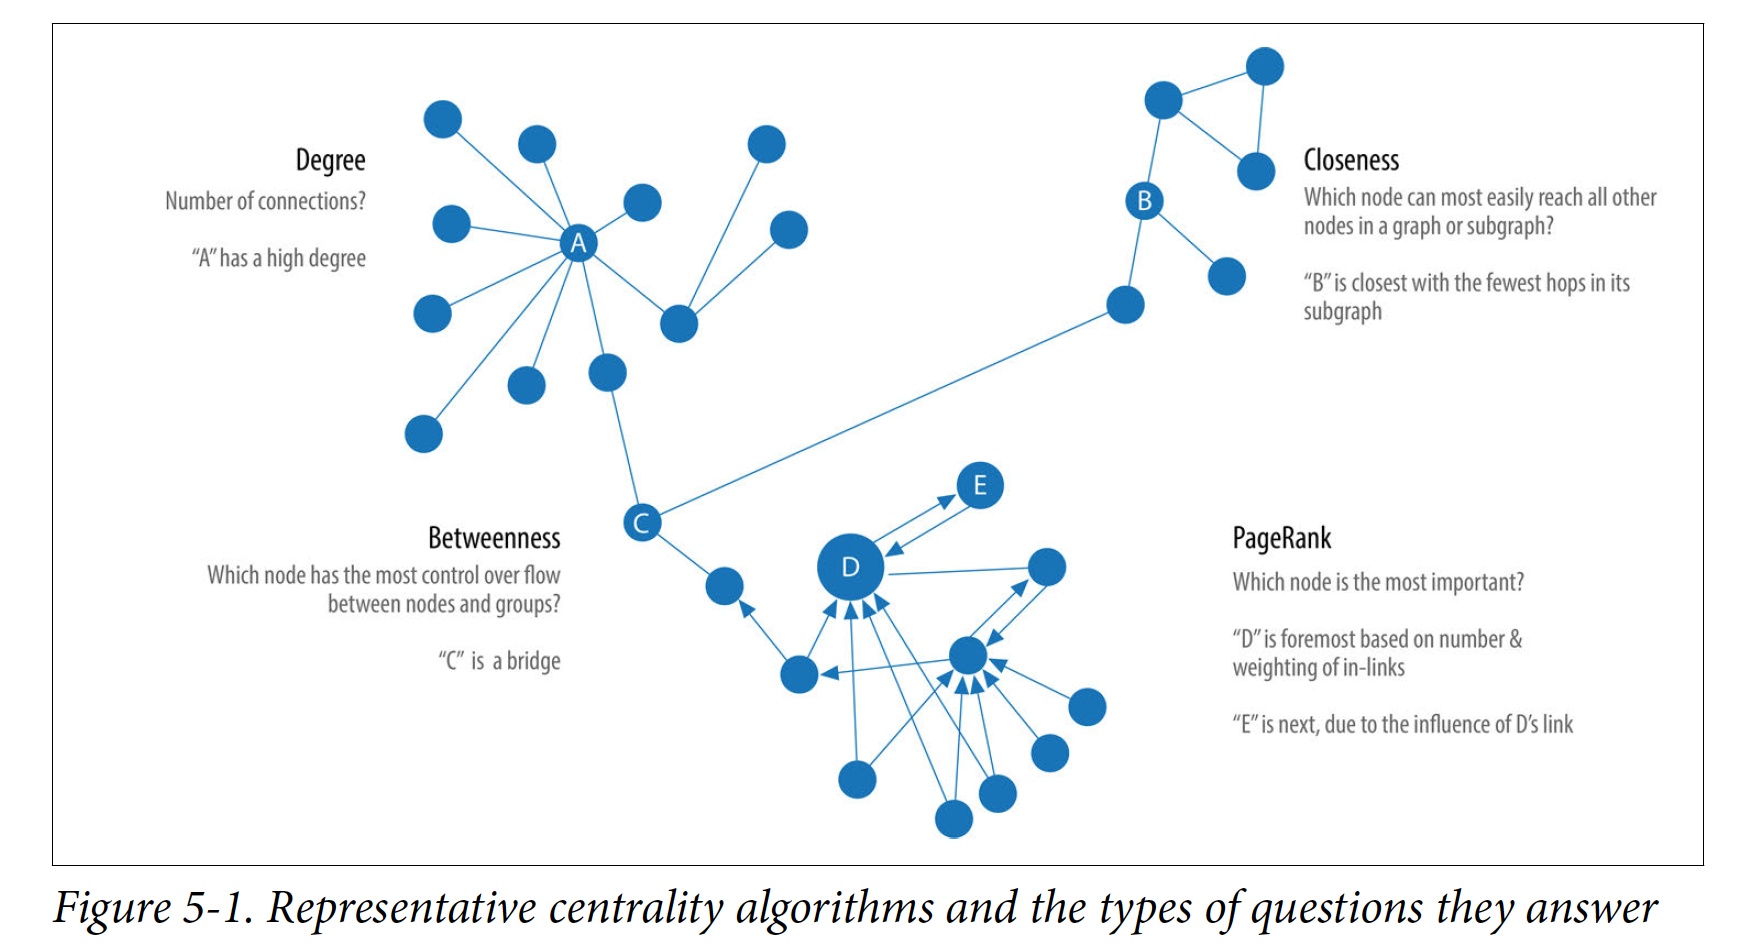

In [3]:
# Graph Algorithms, Practical Examples in Apache Spark and Neo4j by Mark Needham and Amy E. Hodler
from IPython.display import Image
Image(filename="centrality-fig5.1.png")

__Bipartite graph matching (Recommender systems):__ A bipartite graph is one whose vertices can be divided into two disjoint sets. Matching problems on such graphs can be used to model job seekers looking for employment or singles looking for dates. Maximal matching can be used to seat compatible people at tables.  
> `Additional Reference`: Computability, Complexity, and Algorithms; Charles Brubaker and Lance Fortnow https://s3.amazonaws.com/content.udacity-data.com/courses/gt-cs6505/bipartitematching.html  
> `Additional Reference`: Chapter 9 - Bipartite Graph Analysis Fouss, F., Saerens, M., & Shimbo, M. (2016). Bipartite Graph Analysis. In Algorithms and Models for Network Data and Link Analysis (pp. 390-436). Cambridge: Cambridge University Press. doi:10.1017/CBO9781316418321.010 https://www.cambridge.org/core/books/algorithms-and-models-for-network-data-and-link-analysis/bipartite-graph-analysis/270C999701532CEE15D5FE20412A2449

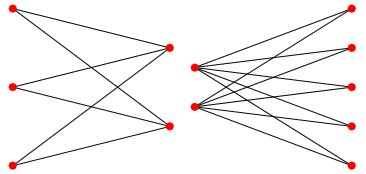

In [9]:
Image(filename="CompleteBipartiteGraph_1000.gif")

__Graph clustering:__ Can a large graph be divided into components that are relatively disjoint (for example, as measured by inter-component links? Among other applications, this task is useful for identifying communities in social networks (of interest to sociologists who wish to understand how human relationships form and evolve) and for partitioning large graphs (of interest to computer scientists who seek to better parallelize graph processing).    
> `For a survery, see`: Rui Xu and Donald Wunsch II. Survey of clustering algorithms. IEEE Transactions
on Neural Networks, 16(3):645{678, 2005.

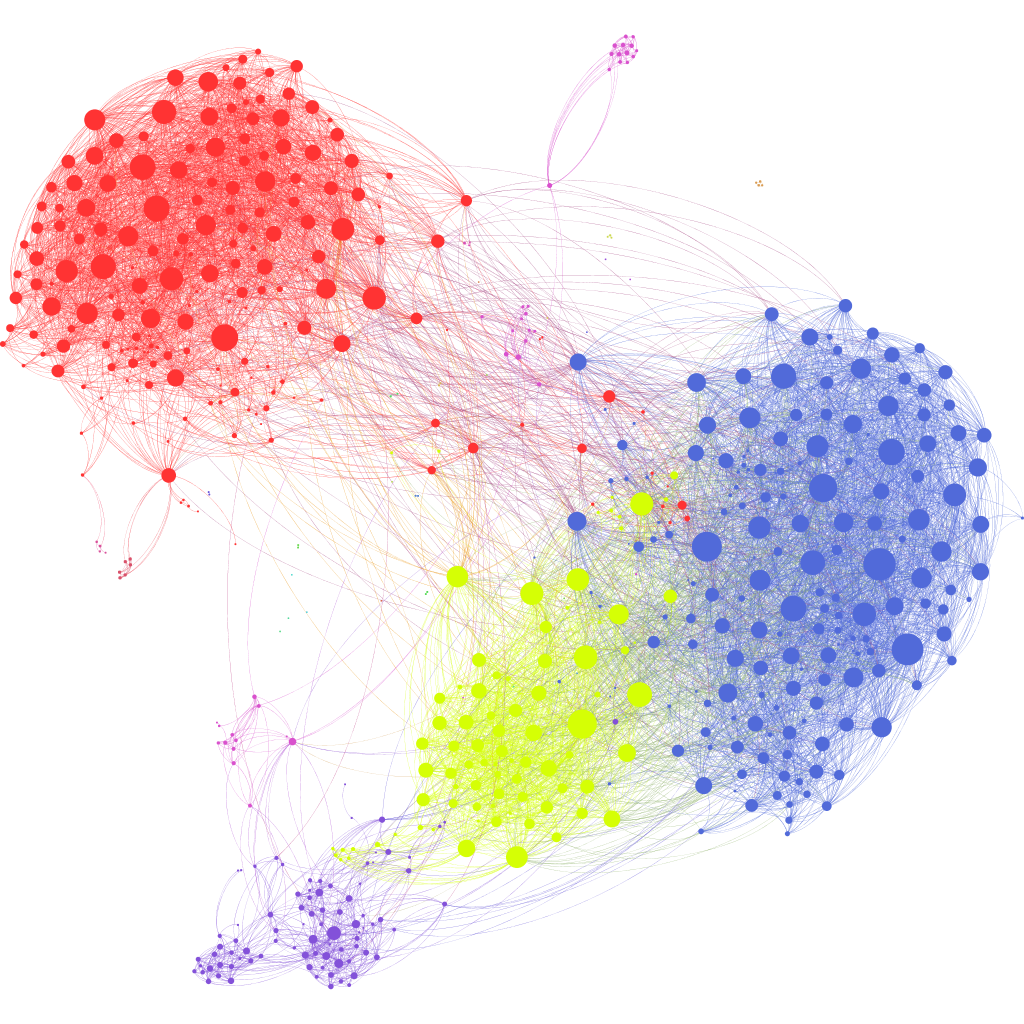

In [16]:
Image(filename="facebook-network.png")

__Minimum spanning trees:__ A minimum spanning tree for a graph G with weighted edges is a tree that contains all vertices of the graph and a subset of edges that minimizes the sum of edge weights. A real-world example of this problem is a telecommunications company that wishes to lay optical fiber to span a number of destinations at the lowest possible cost (where weights denote costs). This approach has also been applied to wide variety of problems, including social networks and the migration of Polynesian islanders. 

[Deriving taxonomies with Word2Vec and Minimum Spanning Trees](https://manning-content.s3.amazonaws.com/download/d/533b533-168c-4f0f-a73d-d9bf4b729fc8/SampleCh06.pdf) 
One way to look at Minimum Spanning Trees is to see them as extracting (in some
sense) the most important connections in the graph. By removing the less important
edges we make the graph sparser, reducing it to its essentials. This link shows you
how to use machine learning and graph processing to turn a simple list of unconnected terms—in this case, a list of animal names—into a connected taxonomy using Minimum Spanning Trees (MSTs).

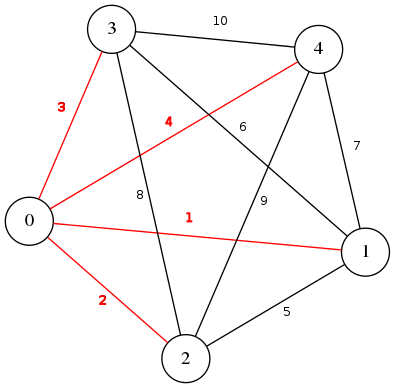

In [11]:
# http://www.martinbroadhurst.com/prims-minimum-spanning-tree-mst-algorithm-in-c.html
Image(filename="mst.png")

__Maximum Flow:__ In a weighted directed graph with two special nodes called the source and the sink, the max flow problem involves computing the amount of "traffic" that can be sent from source to sink given various flow capacities defined by edge weights. Transportation companies (airlines, shipping, etc.) and network operators grapple with complex versions of these problems on a daily basis.

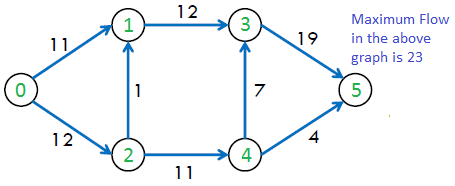

In [13]:
# https://www.geeksforgeeks.org/ford-fulkerson-algorithm-for-maximum-flow-problem/
Image(filename="ford_fulkerson2.png")

# Warm-up questions:

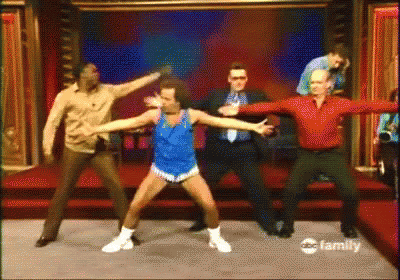

In [9]:
# <--- SOLUTION --->
# RUN THIS CELL AS IS
from IPython.display import Image 
Image(filename="tenor.gif")

In [10]:
# <--- SOLUTION --->
# After you grduate, and you need a little blast of 261 past:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/zki0S2IPZi8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


> __DISCUSSION QUESTION:__ Brainstorm a few other examples of data with an underlying graph structure. 
For one of the examples you come up with...   
__a)__ _what are the nodes & edges?_   
__b)__ _is the graph __weighted/unweighted__? __directed/undirected__? __acyclic__? __connected__?_   
__c)__ _what is a problem/question that could be addressed by one of the 6 types of analysis above?_

# Exercise 2. Data Structures Review.

This lecture is focused on working with graphs in the context of MapReduce style design. We call this type of graph processing "vertex-centric", where the computations revolve around a single vertex and its edges. 

One of the main challenges to "dividing and conquering" computations involving graphs is that the fundamental units of analysis (nodes and edges) carry information about each other so it often takes some careful planning to making sure that the appropriate information is co-located for the calculations we need to perform. Let's briefly review a few key data structures that will be of help. Note that these data structures are not unique to graph algorithms, though they will be particularly helpful for SSSP and PageRank.

__LIFO vs FIFO vs Priority queues__  
A queue is a data structure like a list with the added property of an expected order in which elements are added or removed. In most applications that ordering will be 'last in first out' (LIFO) or 'first in first out' (FIFO). The python double ended queue type `deque` ([docs](https://docs.python.org/3/library/collections.html), [pymotw tutorial](https://pymotw.com/3/collections/deque.html)) is a convenient way to implement either a FIFO or LIFO queue. In contrast, a priority queue maintains a sorted order based on the values of the contents of the sequence so that removing an element will always retrieve the highest/lowest. We usually implement a priority queue in python using `heapq` ([docs](https://docs.python.org/3.0/library/heapq.html), [pymotw tutorial](https://pymotw.com/2/heapq/)).

__Adjacency Matrix vs Adjacency List__  
Adjacency Matrices and Lists are the most common ways to encode a graph. In each, the rows represent nodes and the contents represent edges. In fact, you are already familiar with these data structures from HW3... the co-occurance matrix was a type of adjacency matrix (where we used `1`s and `0`s to encode a connection between two words); similarly the stripes were a form of adjacency list (where instead of storing`0`s for pairs of words that didn't have the connection of being neighbors we just listed the neighbors for each node). Here's a toy graph and its adjacency list representation to refresh your memory:

In [26]:
# a graph is a list of nodes and edges
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B', 1), 
         ('A', 'E', 5), 
         ('B', 'A', 2),
         ('B', 'C', 4),
         ('B', 'D', 2),
         ('B', 'E', 6),
         ('C', 'B', 5),
         ('C', 'D', 2),
         ('D', 'B', 7),
         ('D', 'C', 3),
         ('D', 'E', 3),
         ('E', 'A', 4),
         ('E', 'B', 1),
         ('E', 'D', 5),]
TOY_GRAPH = {'nodes' : nodes, 'edges' : edges}

In [27]:
# retrieving the adjacency list, 
# NOTE that we are discarding edge weights in the process of encoding
ADJ_GRAPH = {}
for node in TOY_GRAPH['nodes']:
    if node not in ADJ_GRAPH:
        ADJ_GRAPH[node] = []
        
    for edge in TOY_GRAPH['edges']:
        if edge[0] == node:
            ADJ_GRAPH[node].append(edge[1])
            
print("Graph as adjecency list")        
print(ADJ_GRAPH)

Graph as adjecency list
{'A': ['B', 'E'], 'B': ['A', 'C', 'D', 'E'], 'C': ['B', 'D'], 'D': ['B', 'C', 'E'], 'E': ['A', 'B', 'D']}


> __DISCUSSION QUESTION:__ In the context of a MapReduce framework, would adjacency matrices or adjacency lists be a better way to represent a graph? Why?

# Exercise 3. Graph Traversal.

For many of the common graph problems introduced in exercise 1 we'll need to systematically visit the nodes in a graph in some kind of order. The idea of "ordering" the nodes in a graph is a little different than "ordering" data in a traditional row/column format. Sometimes a node might be associated with a particular label or value, in which case we might use a sorting strategy just like regular data. However often we'll want to instead use the graph's underlying structure to sequentially examine nodes based on their location. There are two basic ways to do this: breadth-first (BFS) and depth-first (DFS).

## Depth-First Search
__An analogy__   
An analogy you might think about in relation to depth-first search is a maze. The
maze—perhaps one of the people-size ones made of hedges, popular in England—
consists of narrow passages (think of edges) and intersections where passages meet
(vertices).
Suppose that someone is lost in the maze. She knows there’s an exit and plans to
traverse the maze systematically to find it. Fortunately, she has a ball of string and a
marker pen. She starts at some intersection and goes down a randomly chosen
passage, unreeling the string. At the next intersection, she goes down another
randomly chosen passage, and so on, until finally she reaches a dead end.
At the dead end she retraces her path, reeling in the string, until she reaches the
previous intersection. Here she marks the path she’s been down so she won’t take it
again, and tries another path. When she’s marked all the paths leading from that
intersection, she returns to the previous intersection and repeats the process.
The string represents the stack: It “remembers” the path taken to reach a certain
point.

<img src="labyrinth.jpg">

__Depth-First Search and Game Simulations__   
Depth-first searches are often used in simulations of games (and game-like situations
in the real world). In a typical game you can choose one of several possible actions.
Each choice leads to further choices, each of which leads to further choices, and so
on into an ever-expanding tree-shaped graph of possibilities. A choice point corresponds
to a vertex, and the specific choice taken corresponds to an edge, which leads
to another choice-point vertex.

## Breadth-First Search
As we saw in the depth-first search, the algorithm acts as though it wants to get as
far away from the starting point as quickly as possible. In the breadth-first search, on
the other hand, the algorithm likes to stay as close as possible to the starting point.
It visits all the vertices adjacent to the starting vertex, and only then goes further
afield. This kind of search is implemented using a queue instead of a stack.

The breadth-first search has an interesting property: It first finds all the vertices that
are one edge away from the starting point, then all the vertices that are two edges
away, and so on. This is useful if you’re trying to find the shortest path from the
starting vertex to a given vertex. You start a BFS, and when you find the specified
vertex, you know the path you’ve traced so far is the shortest path to the node. If
there were a shorter path, the BFS would have found it already.


__Data Structures & Algorithms in Java__
*Second Edition* by Robert Lafore

http://web.fi.uba.ar/~jvillca/hd/public/books/Data_Structures_and_Algorithms_in_Java_2nd_Edition.pdf

## Other great algorithm books:

__The Algorithm Design manual__ by Steven S. Skiena

__Introduction to Algorithms__ by Thomas H. Cormen, Charles F. Leiserson, Ronald L. Rivest, & Clifford Stein (you may see it referred to as as the CLRS book)

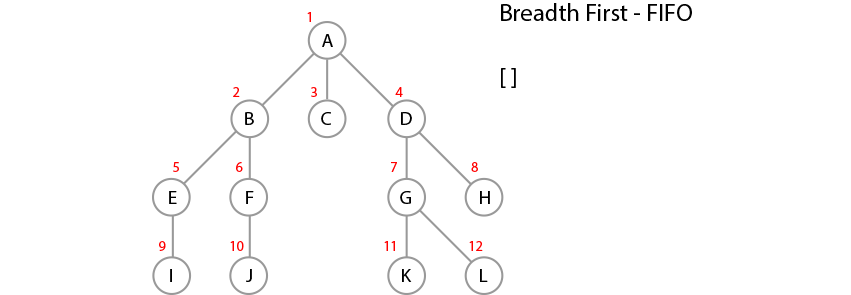

In [5]:
Image(filename="BFS-animation.gif")

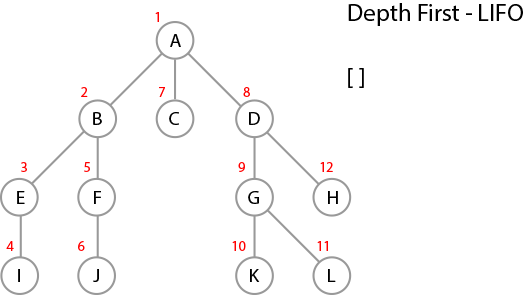

In [6]:
Image(filename="DFS-animation.gif")

> __DISCUSSION QUESTIONS:__
* Explain the difference between BFS and DFS.
* How will these two methods impose different constraints on a distributed algorithm? Why is DFS difficult to parallelize?
* What is the Big O runtime of BFS? (__`Hint:`__ _how many times does BFS examine each node and edge?_)

__INSTRUCTOR TALKING POINTS__

* Explain the difference between BFS and DFS.  

> Breadth-first traversal of a graph:
> - Roughly analogous to level-by-level traversal of an ordered tree
- Start the traversal from an arbitrary vertex
- Visit all of its adjacent vertices
- Then, visit all unvisited adjacent vertices of those visited vertices in last level
- Continue this process, until all vertices have been visited  


* How will these two methods impose different constraints on a distributed algorithm?

> ...

* What is the Big O runtime of BFS?  

> The running time of BFS algorithm is $O(V+E)$ where $V$ is the number of vertices and $E$ is the number of edges.  
BFS pushes each reachable vertex onto the queue and considers each outgoing edge from it once.    
There can't be any faster algorithm: The algorithm must at least look at the entire graph, which has size $O(V+E)$.

* Why is DFS difficult to parallelize

> Depth-first traversal (DFT) is considered to be challenging for effective parallelization. Theoretically, DFT has been
proven to be inherently sequential. This poses practical restrictions in implementing algorithms and applications that are naturally based on DFT. The primary difficulty in parallelizing DFS is the ordering property that requires visiting the outedges of a vertex in order. https://www.hipc.org/hipc2015/documents/HiPC-SRS-Paper/1570220263.pdf
>
> See also:
DEPTH-FIRST SEARCH IS INHERENTLY SEQUENTIAL
John H. REIF * 
https://ac.els-cdn.com/0020019085900249/1-s2.0-0020019085900249-main.pdf?_tid=de8594fd-465e-4b5e-859e-956956556e4a&acdnat=1541248633_f8b675b1dba6ae75398bd8a84ec6b39f

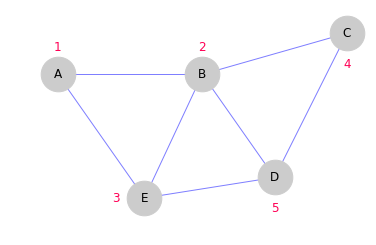

In [24]:
# take a look
G=nx.Graph()

for node in TOY_GRAPH['nodes']:
    G.add_node(node)
for edge in TOY_GRAPH['edges']:
    G.add_edge(edge[0],edge[1],weight=edge[2])

esmall=[(u,v) for (u,v,d) in G.edges(data=True)]

#pos=nx.spring_layout(G) # positions for all nodes
# use the same layout for all graphs for clarity
pos = {  'A': [-1.0,  0.2],
         'B': [ 0.0,  0.2],
         'C': [ 1.0,  0.4],
         'D': [ 0.5, -0.3],
         'E': [-0.4, -0.4]}

pos2 = { 'A': [-1.0,  0.33],
         'B': [ 0.0,  0.33],
         'C': [ 1.0,  0.25],
         'D': [ 0.5, -0.45],
         'E': [-0.6, -0.4]}


# nodes
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color="#cccccc")
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color='b')

# labels
labels = {'A':1, 'B':2, 'E':3, 'C':4, 'D':5}
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
nx.draw_networkx_labels(G,pos2,font_size=12,font_color='#ff0055',font_family='sans-serif', labels=labels)

# Do not draw edge weigths for unweighted graph
# edgelabels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=edgelabels)

plt.axis('off')
plt.show() # display


In [13]:
# https://pythoninwonderland.wordpress.com/2017/03/18/how-to-implement-breadth-first-search-in-python/
# visits all the nodes of a graph (connected component) using BFS (FIFO)
# Here we are traversing the whole graph in a level by level manner, keeping a list of the nodes in the order we visit them.

def bfs(graph, start):
    # keep track of all visited nodes
    explored = []
    # keep track of nodes to be checked
    queue = deque()
    queue.append(start)
    
    # keep looping until there are nodes still to be checked
    while queue:
        # pop shallowest node (first node) from queue
        node = queue.popleft()
        if node not in explored:
            # add node to list of checked nodes
            explored.append(node)
            neighbours = graph[node]
            
            # add neighbours of node to queue
            for neighbour in neighbours:
                queue.append(neighbour)
    return explored

print("BFS Traversal:")
bfs(ADJ_GRAPH,'A') 

BFS Traversal:


['A', 'B', 'E', 'C', 'D']

# Exercise 4. SSSP for unweighted graphs.

The "Single Source Shortest Path" (SSSP) problem is a particular kind of analysis for which we will need to traverse a graph. As implied by the name, when performing SSSP we assume that you have a particular 'starting node' in mind, and want to end up with a number that represents the 'length' of the most efficient route you could take to arrive at a destination (possibly also the path itself which would be a list of connected nodes). Note that in some cases we'll want to calculate this distance ___for all other nodes in the graph___, in others we'll have a ___particular destination node in mind___. Depending on which outcome we're seeking we'd make different design choices.

For an unweighted undirected graph, the 'length' of a path is just the number of edges that are part of that path. We can measure these distances easily by traversing the graph and incrementing counters each time we 'travel' an edge. While doing this traversal, we'll also keep track of which nodes have already been visited so that we can store their shortest distances and so that we know when we've fully traversed the graph. Note that in many graphs there will be more than one path from the source to a given node, in such cases we'll want a way to ensure that we're keeping track of the _shortest_ path not just the path that we happened to find first. BFS guarantees that the first path we find _will_ be the shortest (_can you explain why?_). Here's what it would look like:

In [14]:
# finds shortest path between 2 nodes of a graph using BFS
# Does not consider edge weights

def bfs_shortest_path(graph, start, goal):
    # keep track of explored nodes
    explored = []
    # keep track of all the paths to be checked
    queue = deque()
    # This time we'll keep paths (of nodes) on the queue, not just single nodes
    queue.append([start])

    distance = 0
    # return path if start is goal
    if start == goal:
        return "That was easy! Start = goal"

    # keeps looping until all possible paths have been checked
    while queue:
        # pop the first path from the queue
        path = queue.popleft()
        # get the last node from the path
        node = path[-1]
        if node not in explored:
            # mark node as explored
            explored.append(node)
            
            neighbours = graph[node]
            # go through all neighbour nodes, construct a new path and
            # push it into the queue
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                # return path if neighbour is goal
                if neighbour == goal:
                    distance = len(new_path)-1 # for an unweighted graph, distance is just the number of hops
                    return new_path, distance

            

    # in case there's no path between the 2 nodes
    return "So sorry, but a connecting path doesn't exist :("

print("BFS Shortest paths")
print(bfs_shortest_path(ADJ_GRAPH, 'A', 'D') )

BFS Shortest paths
(['A', 'B', 'D'], 2)


> __DISCUSSION QUESTIONS:__ What would go wrong with this approach if the graph were weighted?

# Exercise 5: Dijkstra's algorithm (SSSP for weighted graphs)

Dijkstra's algorithm uses a modified BFS with weights and a priority queue to solve this problem.

1. new path an improvement over a possible previous one.   
Check whether the path just discovered to the vertex v' is an improvement on the previously discovered path (which had length d)

2. The queue q should not be a FIFO queue.    
Instead, it should be a priority queue where the priorities of the vertices in the queue are their distances recorded in visited. 

pop(q) should be a priority queue extract_min operation that removes the vertex with the smallest distance.

The priority queue must also increase_priority(q,v)    
Increases the priority of an element v already in the queue q. 

A nice intuitive explanation can be found in this 10 minute video: https://www.youtube.com/watch?v=pVfj6mxhdMw

See also __A*__ algorithm: https://youtu.be/eSOJ3ARN5FM

__Assumptions:__
- Dijkstra is a __greedy algorithm__: We assume that we have made the best choice possible in every step of the algorithm. 
- The Graph has __no negative edges__: If edges are negative a greedy algorithm will not suffice.

The __Bellman–Ford__ algorithm can be used on graphs with negative edge weights, as long as the graph contains no negative cycle reachable from the source vertexs. 

With negative cycles the total weight becomes lower each time the cycle is traversed. 
__Johnson's algorithm__ combines Dijkstra's algorithm with Bellman-Ford to handle negative weight edges by removing negative edges and detecting negative cycles.

#### What about longest pahs?
Finding the longest simple path between two vertices is NP-Complete, In fact, it is NP-Complete even if all edge weights are 1   
https://sarielhp.org/misc/funny/longestpath.mp3

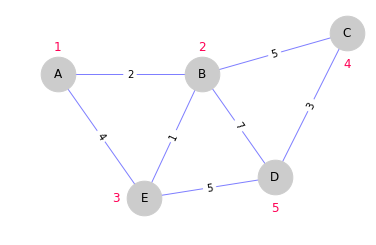

In [25]:
# take a look
G=nx.Graph()

for node in TOY_GRAPH['nodes']:
    G.add_node(node)
for edge in TOY_GRAPH['edges']:
    G.add_edge(edge[0],edge[1],weight=edge[2])

esmall=[(u,v) for (u,v,d) in G.edges(data=True)]

#pos=nx.spring_layout(G) # positions for all nodes
# use the same layout for all graphs for clarity
pos = {  'A': [-1.0,  0.2],
         'B': [ 0.0,  0.2],
         'C': [ 1.0,  0.4],
         'D': [ 0.5, -0.3],
         'E': [-0.4, -0.4]}

pos2 = { 'A': [-1.0,  0.33],
         'B': [ 0.0,  0.33],
         'C': [ 1.0,  0.25],
         'D': [ 0.5, -0.45],
         'E': [-0.6, -0.4]}


# nodes
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color="#cccccc")
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color='b')

# labels
labels = {'A':1, 'B':2, 'E':3, 'C':4, 'D':5}
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
nx.draw_networkx_labels(G,pos2,font_size=12,font_color='#ff0055',font_family='sans-serif', labels=labels)

# Do not draw edge weigths for unweighted graph
edgelabels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgelabels)

plt.axis('off')
plt.show() # display

In [15]:
# helper class for representing graphs
class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = defaultdict(list)
        self.distances = {}
 
    def add_node(self, value):
        self.nodes.add(value)
 
    def add_edge(self, node1, node2, distance = 1,direct = False):
        self.edges[node1].append(node2)
        self.distances[(node1, node2)] = distance
        if not direct:
            self.edges[node2].append(node1)
            self.distances[(node2, node1)] = distance

In [28]:
# Single thread Dijskra's implementation
def dijkstra(graph, initial):
    visited = {initial: 0}
    heap = [(0, initial)] # our priority queue with initial weight 0, and node.
    path = {}

    nodes = set(graph.nodes)

    while nodes and heap:
        
        current_weight, min_node = heapq.heappop(heap)
        try:
            while min_node not in nodes:
                current_weight, min_node = heapq.heappop(heap)
        except IndexError:
            break

        nodes.remove(min_node)
        
        for v in graph.edges[min_node]:
            weight = current_weight + graph.distances[min_node, v]
            if v not in visited or weight < visited[v]:
                visited[v] = weight
                heapq.heappush(heap, (weight, v))
                path[v] = min_node
    return visited

In [29]:
# take a look
g = Graph()

for node in nodes:
    g.add_node(node)
for edge in edges:
    g.add_edge(*edge)
    
print("Shortest distances from node A to all other nodes" )   
print("lengths", dijkstra(g, 'A'))
print("="*50)

Shortest distances from node A to all other nodes
lengths {'A': 0, 'B': 2, 'E': 3, 'C': 7, 'D': 8}


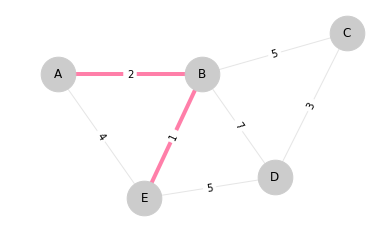

sanity check using networkx
lenghts {'A': 0, 'B': 2, 'E': 3, 'C': 7, 'D': 8}
paths {'A': ['A'], 'B': ['A', 'B'], 'E': ['A', 'B', 'E'], 'C': ['A', 'B', 'C'], 'D': ['A', 'B', 'E', 'D']}


In [18]:
####### networkx ########

G=nx.Graph()

for node in nodes:
  G.add_node(node)
for edge in edges:
  G.add_edge(edge[0],edge[1],weight=edge[2])

esmall=[(u,v) for (u,v,d) in G.edges(data=True)]

# nodes
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color="#cccccc")
# edges
edgeWidths = []
edgeColors = []
for edge in G.edges:
    if edge in [('A', 'B'),('B', 'E'),('E', 'D')]:
        edgeWidths.append(4)
        edgeColors.append("#ff0055")
    else:
        edgeWidths.append(1)
        edgeColors.append("#cccccc")

nx.draw_networkx_edges(G,pos,edgelist=esmall,width=edgeWidths,alpha=0.5,edge_color=edgeColors)

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.axis('off')
plt.show() 

print("="*50)
print("sanity check using networkx")
print("lenghts",nx.single_source_dijkstra_path_length(G,"A") )
print("paths",nx.single_source_dijkstra_path(G,"A") )

> __DISCUSSION QUESTION:__ Why won't this approach scale?

# Exercise 6. Distributed SSSP

#### Graph algorithms typically involve:
- Performing computation at each node
- Processing node-specific data, edge-specific data, and  link structure
- Traversing the graph in some manner

#### Key questions:
- How do you represent graph data in MapReduce?
- How do you process a graph in stateless MapReduce?

*For maximum parallelism, you need the Maps and Reduces to be stateless, i.e. to not depend on any data generated in the same MapReduce job. You cannot control the order in which the maps run, or the reductions.*


### Distributed SSSP Algorithm

#### Node STATES
- Visited
- Queue
- Unvisited

#### Phase 1 - Initialize graph
- Start with Source node (node 1)
- Mark node 1 with distance=0 and tag Q “frontier queue.”
- Mark all other nodes in the unvisited state U, and distance inf


|Key|Value|.|.|
|----|---------|--------|-----|
|Node|Out_nodes|distance|state|
|A|B,E|0|Q|
|B|A,C,D,E|inf|U|
|C|B,D|inf|U|  
|D|B,C,E|inf|U|
|E|A,B,D|inf|U|

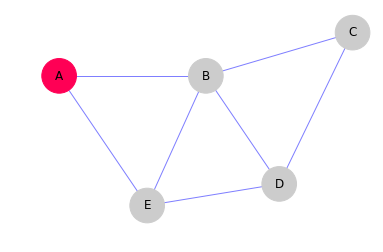

In [202]:
# nodes
color_map = []
for node in G:
    if node == "A":
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=1,alpha=0.5,edge_color='b')

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show() # display

### Mappers: Expand the “frontier”

#### For each frontier node, expand(): 

- Emit list of new frontier nodes tagged with `Q`, and `distance = distance + 1`. 
- Mappers dont know down stream edges from new frontier nodes: tag them as `Null`
- Old frontier updated to visited `V` (once a node has been expanded, we're done with it). 
- Emit all “unvisited nodes” `U`, with no change. 

#### Mapper output:


|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|V|
|B|:|*Null*|1|Q|
|E|:|*Null*|1|Q|
|B|:|A,C,D,E|inf|U|
|C|:|B,D|inf|U|  
|D|:|B,C,E|inf|U|
|E|:|A,B,D|inf|U|


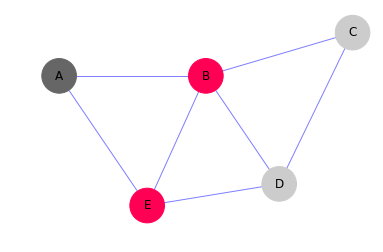

In [203]:
# nodes
color_map = []
for node in G:
    if node == "A":
        color_map.append("#666666")
    elif node == "B" or node == "E":
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")
nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=1,alpha=0.5,edge_color='b')

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show() # display

### Reducers: Merge candidate paths

- The SSSP reducers receive all data for a given key 
- They receive the Null "copies" from newly expanded frontier nodes
- They also recieve info on down stream nodes for that key
- The reducers combine as new key-value pair for next cycle
    - Out_nodes: Union all values
    - Distance: Take the min
    - State: 
        - UNweighted Graph: 
            - `if Q,V:    new_state = V`  
            - `if Q,U:    new_state = Q` 

#### Reducer input:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|B|:|Null|1|Q|
|B|:|A,C,D,E|inf|U|

#### Reducer output:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|B|:|A,C,D,E|1|Q|


### When Does The Algorithm Terminate?
Eventually, all nodes will pass through Q and then V states
(in a connected graph)

#### Stopping conditions:
When there are no output nodes that are frontier (i.e., in Q state). 


### Distributed SSSP from node '1' to each other node:

#### After Initilization phase:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|Q|
|B|:|A,C,D,E|inf|U|
|C|:|B,D|inf|U|  
|D|:|B,C,E|inf|U|
|E|:|A,B,D|inf|U|

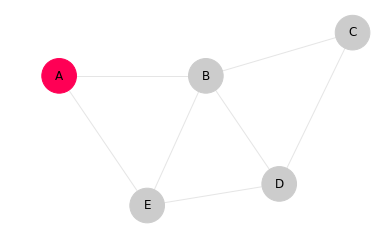

In [227]:
color_map = []
for node in G:
    if node == "A": color_map.append("#ff0055")
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color="#cccccc")
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show()

#### After First Iteration:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|V|
|B|:|A,C,D,E|1|Q|
|C|:|B,D|inf|U|  
|D|:|B,C,E|inf|U|
|E|:|A,B,D|1|Q|

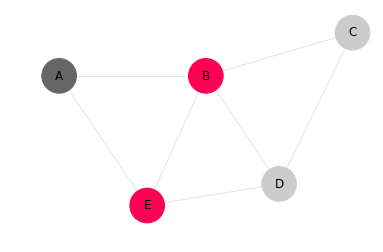

In [228]:
color_map = []
for node in G:
    if node == "A":
        color_map.append("#666666")
    elif node in ["B","E"]:
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color="#cccccc")
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show()

#### After Second Iteration:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|V|
|B|:|A,C,D,E|1|V|
|C|:|B,D|2|Q|  
|D|:|B,C,E|2|Q|
|E|:|A,B,D|1|V|

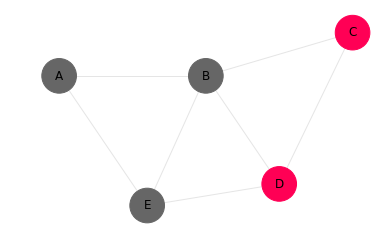

In [229]:
color_map = []
for node in G:
    if node in ["A","B","E"]:
        color_map.append("#666666")
    elif node in ["D","C"]:
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color="#cccccc")
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show()

#### After Third Iteration:

|Key|:|Value|.|.|
|----|-|---------|--------|-----|
|__Node__|:|__Out_nodes__|__distance__|__state__|
|A|:|B,E|0|V|
|B|:|A,C,D,E|1|V|
|C|:|B,D|2|V|  
|D|:|B,C,E|2|V|
|E|:|A,B,D|1|V|

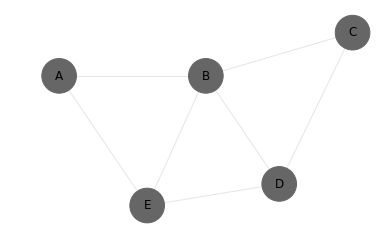

In [230]:
color_map = []
for node in G:
    if node in ["A","B","E","D","C"]:
        color_map.append("#666666")
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)
nx.draw_networkx_edges(G,pos,edgelist=esmall,width=1,alpha=0.5,edge_color="#cccccc")
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
plt.axis('off')
plt.show()

### Will this code work for weighted graphs?


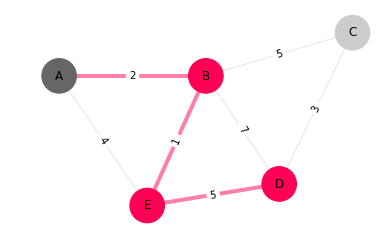

In [221]:
color_map = []
for node in G:
    if node == "A":
        color_map.append("#666666")
    elif node in ["B","E","D"]:
        color_map.append('#ff0055')
    else: color_map.append("#cccccc")

nx.draw_networkx_nodes(G,pos,node_size=1200,node_color=color_map)

# edges
edgeWidths = []
edgeColors = []
for edge in G.edges:
    if edge in [('A', 'B'),('B', 'E'),('E', 'D')]:
        edgeWidths.append(4)
        edgeColors.append("#ff0055")
    else:
        edgeWidths.append(1)
        edgeColors.append("#cccccc")

nx.draw_networkx_edges(G,pos,edgelist=esmall,width=edgeWidths,alpha=0.5,edge_color=edgeColors)

# labels
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

Modify MapReduce Iteration Job for unweighted graphs as follows to get the weighted version:
- If distance to a visited node is shorter then reset status to frontier Q


__The mapper__ 
- same as above.

__The reducer__
- The SSSP reducers receive all data for a given key 
- They receive the Null "copies" from newly expanded frontier nodes
- They also recieve info on down stream nodes for that key
- The reducers combine as new key-value pair for next cycle
    - Out_nodes: Union all values
    - Distance: Take the min
    - State: 
        - UNweighted Graph: 
            - `if Q,V:    new_state = V`  
            - `if Q,U:    new_state = Q` 
        - Weighted Graph: 
            - `if Q,V and distance(Q) < distance(V):    new_state = Q`
                - `else:    new_state = V` 
            - `if Q,U:    new_state = Q` 

# SSSP Quiz

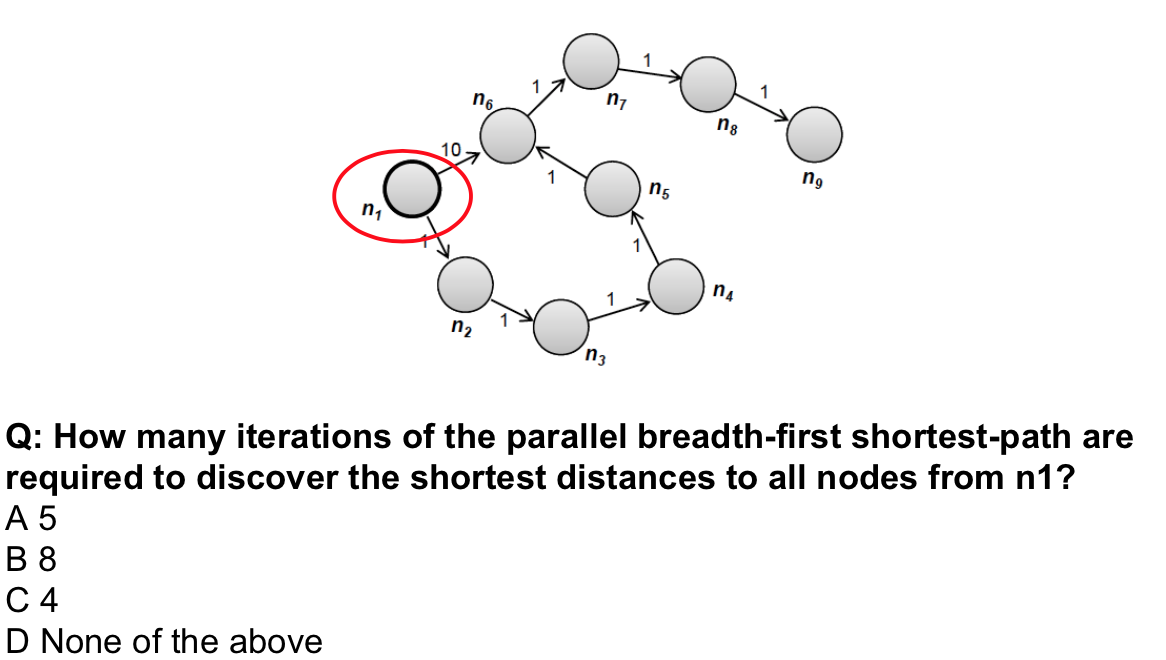

In [2]:
from IPython.display import Image
Image('sssp_quiz.png')

__INSTRUCTOR TALKING POINTS__
> 8!